# Content-based Filtering

### Loading Libraries

In [119]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm                   #pip install tqdm
warnings.filterwarnings('ignore')

### Loading Datasets

In [120]:
movies = pd.read_csv('../data/ml-25m/movies.csv')
movies_with_genres = pd.read_csv('../data/movies_with_genres.csv')
movies_with_year = pd.read_csv('../data/movies_with_year.csv', sep=';')
print(movies.columns)

Index(['movieId', 'title', 'genres'], dtype='object')


### Titel bereinigen

In [121]:
# Extrahiere das Erscheinungsjahr aus dem Titel und füge es als neue Spalte hinzu
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Entferne das Erscheinungsjahr aus dem Titel
movies['title'] = movies['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

movies without year

In [122]:
# Filme ohne Erscheinungsjahr ausgeben
movies_without_year = movies[movies['year'].isna()]
print("the number of movies without year is: ", movies['year'].isna().sum())

# Füge die fehlenden Jahre aus der neuen CSV-Datei ein, basierend auf den Titeln
movies['year'] = movies.apply(
    lambda row: movies_with_year[movies_with_year['title'] == row['title']]['year'].values[0]
    if pd.isnull(row['year']) and row['title'] in movies_with_year ['title'].values
    else row['year'],
    axis=1
)

# Filme ohne Erscheinungsjahr ausgeben
movies_without_year1 = movies[movies['year'].isna()]
print("the number of movies without year is: ", movies['year'].isna().sum())

# Entferne Filme ohne Erscheinungsjahr
movies = movies.dropna(subset=['year'])
movies.isnull().sum()

print(movies.head(5))

the number of movies without year is:  410
the number of movies without year is:  83
   movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                   Adventure|Children|Fantasy  1995  
2                               Comedy|Romance  1995  
3                         Comedy|Drama|Romance  1995  
4                                       Comedy  1995  


### Genres aufbereiten


In [123]:
# Filme ohne Genre ausgeben
print("Anzahl der Filme mit '(no genres listed)':", movies[movies['genres'] == '(no genres listed)'].shape[0])

# Zusammenführen der DataFrames basierend auf den Titeln und Jahren
movies_updated = pd.merge(movies, movies_with_genres[['title', 'year', 'genres']], on=['title', 'year'], how='left', suffixes=('', '_new'))

# Aktualisieren der Genres im movies DataFrame nur für die übereinstimmenden Einträge
movies_updated['genres'] = movies_updated['genres_new'].combine_first(movies_updated['genres'])

# Entferne die temporäre Spalte
movies_updated = movies_updated.drop(columns=['genres_new'])
movies = movies_updated

# Filme ohne Genre ausgeben
print("Anzahl der Filme mit '(no genres listed)':", movies[movies['genres'] == '(no genres listed)'].shape[0])

# Entferne "(no genres listed)" aus der Genre-Liste
movies['genres'] = movies['genres'].replace('(no genres listed)', '')

# Trenne die Genres in separate Listen
genre_list = movies['genres'].str.split('|')

# Finde alle einzigartigen Genres
all_genres = set(genre for sublist in genre_list for genre in sublist if genre)

# Erstelle für jedes Genre eine Spalte und fülle sie mit binären Werten
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x.split('|')))

# Entferne die ursprüngliche 'genres' Spalte
movies = movies.drop(columns=['genres'])

print(movies.head(2))

Anzahl der Filme mit '(no genres listed)': 5002
Anzahl der Filme mit '(no genres listed)': 1257
   movieId      title  year  Documentary  Action  Romance  Sport  Film-Noir  \
0        1  Toy Story  1995            0       0        0      0          0   
1        2    Jumanji  1995            0       0        0      0          0   

   Adventure  IMAX  ...  Fantasy  Drama  News  Game-Show  Thriller  Biography  \
0          1     0  ...        1      0     0          0         0          0   
1          1     0  ...        1      0     0          0         0          0   

   Reality-TV  Musical  Crime  Western  
0           0        0      0        0  
1           0        0      0        0  

[2 rows x 32 columns]


### Nach Null-Werten suchen

In [124]:
movies.info()
movies.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62340 entries, 0 to 62339
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movieId      62340 non-null  int64 
 1   title        62340 non-null  object
 2   year         62340 non-null  object
 3   Documentary  62340 non-null  int64 
 4   Action       62340 non-null  int64 
 5   Romance      62340 non-null  int64 
 6   Sport        62340 non-null  int64 
 7   Film-Noir    62340 non-null  int64 
 8   Adventure    62340 non-null  int64 
 9   IMAX         62340 non-null  int64 
 10  Music        62340 non-null  int64 
 11  Animation    62340 non-null  int64 
 12  Comedy       62340 non-null  int64 
 13  Family       62340 non-null  int64 
 14  Children     62340 non-null  int64 
 15  Sci-Fi       62340 non-null  int64 
 16  Short        62340 non-null  int64 
 17  War          62340 non-null  int64 
 18  Mystery      62340 non-null  int64 
 19  Adult        62340 non-nu

movieId        0
title          0
year           0
Documentary    0
Action         0
Romance        0
Sport          0
Film-Noir      0
Adventure      0
IMAX           0
Music          0
Animation      0
Comedy         0
Family         0
Children       0
Sci-Fi         0
Short          0
War            0
Mystery        0
Adult          0
History        0
Horror         0
Fantasy        0
Drama          0
News           0
Game-Show      0
Thriller       0
Biography      0
Reality-TV     0
Musical        0
Crime          0
Western        0
dtype: int64

### Map user input to get movieId

In [125]:
# Normalisiere die Titel-Spalte: leerzeichen entfernen, kleinbuchstaben, führende Artikel entfernen und ans Ende verschieben

def normalize_title(title):
    articles = ['the', 'a', 'an']
    words = title.strip().split()
    if words[-1].strip(",").lower() in articles:
        return title.strip().lower()
    if words[0].lower() in articles:
        return ', '.join(words[1:]) + ', ' + words[0].capitalize()
    return title.lower()

def alternate_title_format(title):
    articles = ['the', 'a', 'an']
    words = title.strip().split()
    if words[0].lower() in articles:
        return ', '.join(words[1:]) + ', ' + words[0].capitalize()
    if words[-1].strip(",").lower() in articles:
        return words[-1].capitalize() + ' ' + ' '.join(words[:-1]).replace(',', '')
    return title.lower()

# Funktion zur Zuordnung der IDs
def map_movie_ids(movies_df, user_ratings_input, cinema_movies_input):
    # Normalisieren der Titelspalte des DataFrames
    movies_df['normalized_title'] = movies_df['title'].apply(normalize_title)
    movies_df['alternate_title'] = movies_df['title'].apply(alternate_title_format)

    def get_movie_id(title, year):
        normalized_title = normalize_title(title)
        alternate_title = alternate_title_format(title)
        
        filtered_movies = movies_df[((movies_df['normalized_title'] == normalized_title) | (movies_df['alternate_title'] == alternate_title)) & (movies_df['year'] == str(year))]
        if not filtered_movies.empty:
            return filtered_movies.iloc[0]['movieId']
        else:
            print(f"{title} ({year}) not found")
            return None

    # IDs zu den Filmen im user_ratings_input Array hinzufügen
    mapped_user_ratings = []
    for rating in user_ratings_input:
        movie_id = get_movie_id(rating['title'], rating['year'])
        mapped_user_ratings.append({**rating, 'movieId': movie_id})
    
    # IDs zu den Filmen im cinema_movies_input Array hinzufügen
    mapped_cinema_movies = []
    for movie in cinema_movies_input:
        movie_id = get_movie_id(movie['title'], movie['year'])
        mapped_cinema_movies.append({**movie, 'movieId': movie_id})
    
    return mapped_user_ratings, mapped_cinema_movies

### Feature Set: Genre

In [126]:
# Funktion zur Extraktion von Filmmerkmalen
def get_movie_features(movies, movie_id):
    filtered_movie = movies[movies['movieId'] == movie_id]
    if not filtered_movie.empty:
        # Wähle nur die numerischen Spalten aus, die für die Berechnung der Ähnlichkeiten verwendet werden sollen, außer 'movieId'
        numeric_features = filtered_movie.drop(columns=['movieId']).select_dtypes(include=[np.number])
        return numeric_features.iloc[0]
    else:
        print(f"Movie with ID {movie_id} not found")
        return None

# Funktion zur Empfehlung von Filmen
def recommend_movies(user_ratings_input, cinema_movies_input):
    
    # Schritt 1: Extrahieren der Merkmale der vom Nutzer bewerteten Filme
    user_movie_features = []
    has_positive_ratings = any('rating' in movie and movie['rating'] >= 2.5 for movie in user_ratings_input)

    for movie in user_ratings_input:
        if has_positive_ratings and movie.get('rating', 0) >= 2.5:
            features = get_movie_features(movies, movie['movieId'])
            if features is not None:
                user_movie_features.append(features.values)
        elif not has_positive_ratings and movie.get('rating', 0) < 2.5:
            features = get_movie_features(movies, movie['movieId'])
            if features is not None:
                user_movie_features.append(features.values)
    
    # Schritt 2: Feature-Vektorisierung
    if not user_movie_features:
        raise ValueError("Keine positiv bewerteten Filme vorhanden.")
    
    user_profile = np.mean(user_movie_features, axis=0)
    
    # Schritt 3: Ähnlichkeitsberechnung
    kino_movie_features = []
    for kino_movie in cinema_movies_input:
        features = get_movie_features(movies, kino_movie['movieId'])
        if features is not None:
            kino_movie_features.append(features.values)
    
    if not kino_movie_features:
        raise ValueError("Keine Kino-Filme mit passenden Features gefunden.")
    
    similarities = cosine_similarity([user_profile], kino_movie_features)[0]
    similarities = similarities * 100
    
    # Schritt 4: Sortierung und Ausgabe
    # Falls der Nutzer positive Bewertungen abgegeben hat, sortiere nach absteigender Ähnlichkeit
    # Andernfalls sortiere nach aufsteigender Ähnlichkeit
    cinema_movies_with_similarity = []
    for i, kino_movie in enumerate(cinema_movies_input):
        kino_movie_with_similarity = {
            "externalId": kino_movie['externalId'],
            "movieTitle": kino_movie['title'],
            "year": kino_movie['year'],
            "score": similarities[i]
        }
        cinema_movies_with_similarity.append(kino_movie_with_similarity)
    
    if has_positive_ratings:
        sorted_cinema_movies = sorted(cinema_movies_with_similarity, key=lambda x: x['score'], reverse=True)
    else:
        sorted_cinema_movies = sorted(cinema_movies_with_similarity, key=lambda x: x['score'])
    
    return sorted_cinema_movies

### Test

In [127]:
# Beispiel-Daten
user_rated_movies = [
    {"externalId": "1", "title": "Emil and the Detectives", "year": 1964, "rating": 4.5},
    {"externalId": "2", "title": "Pride and Prejudice", "year": 2003, "rating": 1.5},
    {"externalId": "3", "title": "La La Land", "year": 2016, "rating": 2.0}
]
cinema_movies = [
    {"externalId": "4", "title": "Black Panther", "year": 2017},
    {"externalId": "5", "title": "Avengers: Infinity War - Part I", "year": 2018},
    {"externalId": "6", "title": "A Star Is Born", "year": 2018},
    {"externalId": "7", "title": "Bohemian Rhapsody", "year": 2018},
    {"externalId": "8", "title": "Deadpool 2", "year": 2018},
    {"externalId": "9", "title": "Spider-Man: Into the Spider-Verse", "year": 2018},
    {"externalId": "10", "title": "Crazy Rich Asians", "year": 2018},
    {"externalId": "11", "title": "Mission: Impossible - Fallout", "year": 2018},
    {"externalId": "12", "title": "Solo: A Star Wars Story", "year": 2018},
    {"externalId": "13", "title": "Aquaman", "year": 2018},
    {"externalId": "14", "title": "The Meg", "year": 2018},
    {"externalId": "15", "title": "Ready Player One", "year": 2018},
    {"externalId": "16", "title": "Jurassic World: Fallen Kingdom", "year": 2018}
]

# Map IDs
mapped_user_ratings, mapped_movies  = map_movie_ids(movies, user_rated_movies, cinema_movies)
# print("Mapped Movies:", mapped_movies)
# print("Mapped User Ratings:", mapped_user_ratings)
# Funktion aufrufen
recommended_cinema_movies = recommend_movies(mapped_user_ratings, mapped_movies)
for movie in recommended_cinema_movies:
    print(f"External ID: {movie['externalId']}, Title: {movie['movieTitle']}, Year: {movie['year']}, Score: {movie['score']:.2f}")

External ID: 4, Title: Black Panther, Year: 2017, Score: 57.74
External ID: 5, Title: Avengers: Infinity War - Part I, Year: 2018, Score: 57.74
External ID: 8, Title: Deadpool 2, Year: 2018, Score: 57.74
External ID: 11, Title: Mission: Impossible - Fallout, Year: 2018, Score: 57.74
External ID: 9, Title: Spider-Man: Into the Spider-Verse, Year: 2018, Score: 50.00
External ID: 10, Title: Crazy Rich Asians, Year: 2018, Score: 50.00
External ID: 12, Title: Solo: A Star Wars Story, Year: 2018, Score: 50.00
External ID: 16, Title: Jurassic World: Fallen Kingdom, Year: 2018, Score: 44.72
External ID: 13, Title: Aquaman, Year: 2018, Score: 28.87
External ID: 15, Title: Ready Player One, Year: 2018, Score: 28.87
External ID: 14, Title: The Meg, Year: 2018, Score: 25.00
External ID: 6, Title: A Star Is Born, Year: 2018, Score: 0.00
External ID: 7, Title: Bohemian Rhapsody, Year: 2018, Score: 0.00


### Evaluate Content-Based Filtering

In [128]:
# Laden der Ratings-Daten
ratings = pd.read_csv('../data/ml-25m/ratings.csv')

# Splitten der Daten in Trainings- und Testdatensets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Überprüfen der Splits
print(f"Trainingsdaten: {train_ratings.shape}")
print(f"Testdaten: {test_ratings.shape}")

Trainingsdaten: (20000076, 4)
Testdaten: (5000019, 4)


In [129]:
def plot_genre_correlation_matrix(movies):
    # Extrahiere alle Spaltennamen, die Genres darstellen
    genre_features = [col for col in movies.columns if col not in ['movieId', 'title', 'year', 'normalized_title', 'alternate_title'] and movies[col].dtype in [np.int64, np.int32]]
    
    # Berechne die Korrelationsmatrix für die Genres
    correlation_matrix = movies[genre_features].corr()
    
    # Plotten der Korrelationsmatrix ohne Zahlen
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix for Genres')
    plt.show()

In [130]:
def get_user_ratings(train_ratings, test_ratings):
    # Einen zufälligen Benutzer aus dem Trainingsset auswählen
    random_user_id = train_ratings['userId'].sample(1).iloc[0]

    # Alle Bewertungen dieses Benutzers aus dem Trainings- und Testdatenset extrahieren
    user_train_ratings = train_ratings[train_ratings['userId'] == random_user_id]
    user_test_ratings = test_ratings[test_ratings['userId'] == random_user_id]

    # Extrahiere die Filme und die tatsächlichen Bewertungen aus dem Testdatenset
    test_movies = []
    actual_ratings = []
    for idx, row in user_test_ratings.iterrows():
        movie_id = row['movieId']
        actual_rating = row['rating']
        test_movies.append(movie_id)
        actual_ratings.append({"movieId": movie_id, "actual_rating": actual_rating})

    return random_user_id, user_train_ratings, test_movies, actual_ratings

In [131]:
def predict_rating(random_user_id, user_train_ratings, test_movies, actual_ratings, movies):
    # Formatieren der Trainingsbewertungen für die Empfehlung
    user_rated_movies_formatted = []
    for idx, row in user_train_ratings.iterrows():
        movie = movies[movies['movieId'] == row['movieId']]
        if not movie.empty:
            try:
                user_rated_movies_formatted.append({
                    "externalId": idx,
                    "title": movie.iloc[0]['title'],
                    "year": int(movie.iloc[0]['year']),
                    "rating": row['rating']
                })
            except ValueError:
                print(f"Skipping movie with invalid year: {movie.iloc[0]['title']} ({movie.iloc[0]['year']})")

    # Formatieren der Testfilme für die Empfehlung
    test_movies_formatted = []
    for movie_id in test_movies:
        movie = movies[movies['movieId'] == movie_id]
        if not movie.empty:
            try:
                test_movies_formatted.append({
                    "externalId": movie_id,
                    "title": movie.iloc[0]['title'],
                    "year": int(movie.iloc[0]['year'])
                })
            except ValueError:
                print(f"Skipping movie with invalid year: {movie.iloc[0]['title']} ({movie.iloc[0]['year']})")

    # Verwenden der vorhandenen Mapping-Funktion, um IDs zuzuordnen
    if not user_rated_movies_formatted or not test_movies_formatted:
        return []

    mapped_user_ratings, mapped_test_movies = map_movie_ids(movies, user_rated_movies_formatted, test_movies_formatted)

    # Vorhersage der Bewertungen
    recommended_movies = recommend_movies(mapped_user_ratings, mapped_test_movies)
    
    # Ergebnisliste
    results = []
    for idx, movie in enumerate(recommended_movies):
        predicted_score = movie['score'] / 20  # Konvertiere den Score von 0-100 auf 0-5
        actual_rating = next((item['actual_rating'] for item in actual_ratings if item['movieId'] == movie['externalId']), None)
        results.append({"userId": random_user_id, "movieId": movie['externalId'], "actual_rating": actual_rating, "predicted_rating": predicted_score})

    return results

Processing users:  24%|██▍       | 24/100 [04:30<08:45,  6.92s/it]

Skipping movie with invalid year: Salad Fingers (2004–)


Processing users: 100%|██████████| 100/100 [17:42<00:00, 10.62s/it]


Vorhersagen für 100 Benutzer gespeichert in 'predicted_ratings_multiple_users.csv'
RMSE: 1.5133792978924716
MAE: 1.2148965541849146
MAPE: 46.24374719214547%


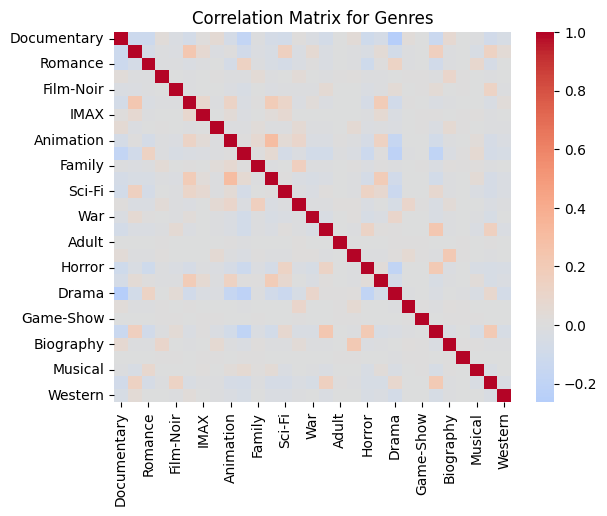

In [132]:
def predict_ratings_for_multiple_users(ratings, movies, num_users=10):
    all_results = []

    # Führe den train_test_split einmal durch
    train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

    for _ in tqdm(range(num_users), desc="Processing users"):
        random_user_id, user_train_ratings, test_movies, actual_ratings = get_user_ratings(train_ratings, test_ratings)
        results = predict_rating(random_user_id, user_train_ratings, test_movies, actual_ratings, movies)
        all_results.extend(results)

    all_results_df = pd.DataFrame(all_results)
    all_results_df.to_csv('predicted_ratings_multiple_users.csv', index=False)

    actuals = all_results_df['actual_rating'].tolist()
    predictions = all_results_df['predicted_rating'].tolist()
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100

    print(f"Vorhersagen für {num_users} Benutzer gespeichert in 'predicted_ratings_multiple_users.csv'")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}%")

    # Plot the genre correlation matrix
    plot_genre_correlation_matrix(movies)

# Beispielaufruf
predict_ratings_for_multiple_users(ratings, movies, num_users=100)
